In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


sns.set_context("poster")
sns.set_style("ticks")

In [2]:
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
SEXMAC_MAPPINGS = {
    "andy": "-",
    "male": "M",
    "mostly_male": "M",
    "female": "F",
    "mostly_female": "F"
}

## Gender

In [3]:
gender_data = sqlContext.read.format("csv").options(header="true", delimiter="\t").load("data/AuthorityEthnea.txt")

In [4]:
gender_data.head()

Row(auid=u'9731334_2', Ethnea=u'ENGLISH', Genni=u'M', SexMac=u'mostly_male', SSNgender=u'-')

In [5]:
gender_data = gender_data.rdd.map(lambda x: (x.auid, x.Genni, SEXMAC_MAPPINGS[x.SexMac], x.SSNgender))
gender_data.take(1)

[(u'9731334_2', u'M', 'M', u'-')]

In [6]:
def get_gender_eth_dist(data, gender_data, gender_idx=1):
    gender_eth_data = data.map(
        lambda x: (x[0], (x[44], x[46]))).reduceByKey(
        lambda x, y: x).map(lambda x: x[1]).join(
        gender_data.map(lambda x: (x[0], x[gender_idx]))).map(
        lambda x: (x[1], 1)).countByKey()
    df_gender_eth = pd.DataFrame([k + (v,) for k,v in gender_eth_data.iteritems()],
                               columns=["Ethnicity", "Gender", "Counts"])
    return df_gender_eth

def get_ethnic_pivot(df, ethnicities=tuple(TOP_15_ETHNICITIES)):
    df = df.copy()
    if ethnicities is not None:
        df["Ethnicity"] = df["Ethnicity"].astype(
            "category", categories=ethnicities + ("OVERALL",), ordered=False).fillna("OTHER")
    else:
        ethnicities = tuple(df["Ethnicity"].unique())
        df["Ethnicity"] = df["Ethnicity"].astype(
            "category", categories=ethnicities + ("OVERALL",), ordered=False)
    df_pivot = df.pivot_table(index="Ethnicity", columns="Gender", values="Counts", aggfunc=sum)
    df_pivot.ix["OVERALL"] = df_pivot.sum().values
    return df_pivot

def get_proportions(df):
    return df.divide(df.sum(axis=1), axis=0)

def get_fm_ratio(df):
    df = get_proportions(df)
    df_t = df[["-"]].copy()
    df_t["F/(M+F)"] = df["F"] / (df["F"] + df["M"])
    return df_t

def get_unique_authors(data):
    n_auids = data.map(lambda x: x[44]).distinct().count()
    print "Total unique authors: ", n_auids
    
def merge_tables(df_pivots, keys=("Genni", "Sex Machine", "SSN Gender")):
    df_t = df_pivots[0].sum(axis=1)
    df_ethnicities = pd.DataFrame( df_t / df_t.ix[df_t.index != "OVERALL"].sum(),
                                  columns=["Proportion"])
    df_final = pd.concat([df_ethnicities,] + df_pivots,
                         keys=("Ethnicity",) + keys, axis=1)
    df_final = df_final.reindex(df_ethnicities.index)
    df_final_props = pd.concat([df_ethnicities,] + [get_proportions(df) for df in df_pivots],
                         keys=("Ethnicity",) + keys, axis=1)
    df_final_props = df_final_props.reindex(df_ethnicities.index)
    df_final_fm_ratio = pd.concat([df_ethnicities,] + [get_fm_ratio(df) for df in df_pivots],
                         keys=("Ethnicity",) + keys, axis=1)
    df_final_fm_ratio = df_final_fm_ratio.reindex(df_ethnicities.index)
    return df_final, df_final_props, df_final_fm_ratio

MATCH_GENDERS = set(("M", "F"))
def disagreements(x):
    sm, ssn, sm_valid, ssn_valid = 0, 0, 0, 0
    if (x[1] in MATCH_GENDERS):
        if (x[2] in MATCH_GENDERS):
            sm_valid = 1
            sm = 1 if x[1] == x[2] else 0
        if (x[3] in MATCH_GENDERS):
            ssn_valid = 1
            ssn = 1 if x[1] == x[3] else 0
    return (sm, ssn, sm_valid, ssn_valid, 1)
    

def get_matches(data, gender_data):
    eth_match_data = data.map(
        lambda x: (x[0], (x[44], x[46]))).reduceByKey(
        lambda x, y: x).map(lambda x: x[1]).join(
        gender_data.map(lambda x: (x[0], disagreements(x)))).map(
        lambda x: (x[1][0], x[1][1])).reduceByKey(
        lambda x,y: tuple(x1 + y1 for x1, y1 in zip(x,y))).collectAsMap()
    df_eth_match = pd.DataFrame([(k,) + v for k, v in eth_match_data.iteritems()],
                               columns=["Ethnicity", "G=SM", "G=SSN", "SM_valid", "SSN_valid", "Total"])
    return df_eth_match

def get_ethnic_grouping(df, ethnicities=tuple(TOP_15_ETHNICITIES)):
    df = df.copy()
    if ethnicities is not None:
        df["Ethnicity"] = df["Ethnicity"].astype(
            "category", categories=ethnicities+ ("OVERALL",), ordered=False).fillna("OTHER")
    else:
        ethnicities = tuple(df["Ethnicity"].unique())
        df["Ethnicity"] = df["Ethnicity"].astype(
            "category", categories=ethnicities + ("OVERALL",), ordered=False)
    df = df.groupby("Ethnicity").sum()
    df = df.sort_values("Total", ascending=False)
    df.ix["OVERALL", :] = df.sum().values
    df["G=SM"] = df["G=SM"]/df["SM_valid"]
    df["G=SSN"] = df["G=SSN"]/df["SSN_valid"]
    return df

## First author

In [7]:
data = sc.textFile("out/Training_2002_2005.first_author.txt").map(lambda x: x.split("\t"))

In [8]:
pd.DataFrame(data.take(1)[0], columns=["Value"])

,Value
0,16526454
1,2005
2,J AOAC Int
3,11
4,53
5,1
6,JAPAN
7,1
8,0
9,0


In [9]:
get_unique_authors(data)

Total unique authors:  824830


In [10]:
 data.map(lambda x: (x[44], x[46])).take(3)

[(u'6185531_1', u'JAPANESE'),
 (u'6185531_1', u'JAPANESE'),
 (u'9706394_2', u'JAPANESE')]

### Generate table data

In [11]:
df_genni = get_gender_eth_dist(data, gender_data, gender_idx=1)
df_sexmac = get_gender_eth_dist(data, gender_data, gender_idx=2)
df_ssn = get_gender_eth_dist(data, gender_data, gender_idx=3)
df_eth_match = get_matches(data, gender_data)

#### All ethnicities

In [12]:
df_pivot_genni = get_ethnic_pivot(df_genni, ethnicities=None)
df_pivot_sexmac = get_ethnic_pivot(df_sexmac, ethnicities=None)
df_pivot_ssn = get_ethnic_pivot(df_ssn, ethnicities=None)

In [13]:
df_final, df_final_props, df_final_fm_ratio = merge_tables([df_pivot_genni, df_pivot_sexmac, df_pivot_ssn])
df_final

Ethnicity     Genni                     Sex Machine            \
Gender        Proportion         -         F         M           -         F   
Ethnicity                                                                      
JAPANESE    8.653961e-02   17014.0   20722.0  102285.0     19727.0   22457.0   
CHINESE     9.314530e-02  101344.0   14401.0   34964.0    130570.0    6360.0   
GREEK       1.176886e-02    1287.0    4863.0   12892.0      2771.0    4557.0   
INDONESIAN  2.194068e-04     182.0      81.0      92.0       244.0      53.0   
TURKISH     1.861620e-02    3920.0    7931.0   18270.0      8744.0    6028.0   
POLYNESIAN  3.708284e-06       2.0       NaN       4.0         6.0       NaN   
THAI        3.636591e-03    4025.0    1030.0     829.0      5541.0     173.0   
BALTIC      7.336222e-04      52.0     549.0     586.0       252.0     418.0   
ITALIAN     5.404082e-02    2624.0   31981.0   52833.0      4298.0   34216.0   
ENGLISH     2.543636e-01   23567.0  129846.0  258147.0     25983.0  129659.0   
TOOSHORT    6.180474e-07       1.0       NaN       NaN         1.0       NaN   
INDIAN      4.287580e-02   20522.0   15143.0   33708.0     37060.0   11867.0   
ISRAELI     1.303029e-02    2324.0    6002.0   12757.0      2334.0    5929.0   
KOREAN      2.233809e-02   19021.0    6211.0   10911.0     23880.0    5992.0   
NORDIC      3.845058e-02    3073.0   26046.0   33094.0      7083.0   24527.0   
UNKNOWN     2.126083e-03     667.0    1198.0    1575.0       742.0    1153.0   
ARAB        3.000002e-02    8327.0    9035.0   31178.0     13642.0    7461.0   
GERMAN      1.009988e-01    6125.0   42374.0  114917.0     10509.0   41532.0   
MONGOLIAN   1.421509e-05      20.0       NaN       3.0        23.0       NaN   
VIETNAMESE  5.729299e-04     518.0      86.0     323.0       601.0     114.0   
FRENCH      6.703094e-02    5771.0   38093.0   64592.0     15073.0   35509.0   
HISPANIC    7.711068e-02    8974.0   50311.0   65480.0     17826.0   45773.0   
DUTCH       2.868914e-02    4400.0   14815.0   27204.0      5552.0   14420.0   
CARIBBEAN   1.038320e-04      40.0      43.0      85.0        71.0      33.0   
HUNGARIAN   5.370213e-03     263.0    2731.0    5695.0      3490.0    2535.0   
SLAV        4.089125e-02    5177.0   27155.0   33830.0     10733.0   23776.0   
AFRICAN     5.565516e-03    3111.0    1461.0    4433.0      4882.0    1121.0   
ROMANIAN    1.763289e-03     157.0    1267.0    1429.0       419.0    1172.0   
OVERALL     1.000000e+00  242508.0  453375.0  922116.0    352057.0  426835.0   

                     SSN Gender                      
Gender             M          -         F         M  
Ethnicity                                            
JAPANESE     97837.0    54947.0   18095.0   66979.0  
CHINESE      13779.0   124203.0    8797.0   17709.0  
GREEK        11714.0     3959.0    4113.0   10970.0  
INDONESIAN      58.0      241.0      59.0      55.0  
TURKISH      15349.0    16273.0    3527.0   10321.0  
POLYNESIAN       NaN        2.0       4.0       NaN  
THAI           170.0     5306.0     332.0     246.0  
BALTIC         517.0      636.0     356.0     195.0  
ITALIAN      48924.0     8881.0   32302.0   46255.0  
ENGLISH     255918.0    39159.0  123768.0  248633.0  
TOOSHORT         NaN        1.0       NaN       NaN  
INDIAN       20446.0    35172.0   12263.0   21938.0  
ISRAELI      12820.0     5777.0    4748.0   10558.0  
KOREAN        6271.0    30963.0    1905.0    3275.0  
NORDIC       30603.0    18896.0   20795.0   22522.0  
UNKNOWN       1545.0      884.0    1141.0    1415.0  
ARAB         27437.0    16876.0    7250.0   24414.0  
GERMAN      111375.0    27271.0   38457.0   97688.0  
MONGOLIAN        NaN       20.0       NaN       3.0  
VIETNAMESE     212.0      669.0      54.0     204.0  
FRENCH       57874.0    19025.0   37793.0   51638.0  
HISPANIC     61166.0    20267.0   44563.0   59935.0  
DUTCH        26447.0    15536.0   11919.0   18964.0  
CARIBBEAN       64.0       56.0      37.0      75.

In [14]:
df_eth_matches_prop = get_ethnic_grouping(df_eth_match, ethnicities=None)
df_all = df_final_props.copy()
df_all[df_eth_matches_prop.columns] = df_eth_matches_prop
df_all

Ethnicity     Genni                     Sex Machine            \
Gender        Proportion         -         F         M           -         F   
Ethnicity                                                                      
JAPANESE    8.653961e-02  0.121510  0.147992  0.730498    0.140886  0.160383   
CHINESE     9.314530e-02  0.672448  0.095555  0.231997    0.866372  0.042201   
GREEK       1.176886e-02  0.067587  0.255383  0.677030    0.145520  0.239313   
INDONESIAN  2.194068e-04  0.512676  0.228169  0.259155    0.687324  0.149296   
TURKISH     1.861620e-02  0.130142  0.263305  0.606554    0.290296  0.200126   
POLYNESIAN  3.708284e-06  0.333333       NaN  0.666667    1.000000       NaN   
THAI        3.636591e-03  0.684058  0.175051  0.140891    0.941706  0.029402   
BALTIC      7.336222e-04  0.043808  0.462511  0.493682    0.212300  0.352148   
ITALIAN     5.404082e-02  0.030010  0.365756  0.604234    0.049155  0.391317   
ENGLISH     2.543636e-01  0.057263  0.315497  0.627240    0.063133  0.315043   
TOOSHORT    6.180474e-07  1.000000       NaN       NaN    1.000000       NaN   
INDIAN      4.287580e-02  0.295821  0.218284  0.485895    0.534214  0.171061   
ISRAELI     1.303029e-02  0.110231  0.284684  0.605085    0.110705  0.281222   
KOREAN      2.233809e-02  0.526271  0.171845  0.301884    0.660709  0.165786   
NORDIC      3.845058e-02  0.049395  0.418658  0.531947    0.113851  0.394242   
UNKNOWN     2.126083e-03  0.193895  0.348256  0.457849    0.215698  0.335174   
ARAB        3.000002e-02  0.171549  0.186135  0.642316    0.281047  0.153708   
GERMAN      1.009988e-01  0.037481  0.259301  0.703218    0.064308  0.254149   
MONGOLIAN   1.421509e-05  0.869565       NaN  0.130435    1.000000       NaN   
VIETNAMESE  5.729299e-04  0.558792  0.092772  0.348436    0.648328  0.122977   
FRENCH      6.703094e-02  0.053211  0.351230  0.595559    0.138978  0.327405   
HISPANIC    7.711068e-02  0.071927  0.403246  0.524827    0.142877  0.366874   
DUTCH       2.868914e-02  0.094789  0.319158  0.586053    0.119606  0.310649   
CARIBBEAN   1.038320e-04  0.238095  0.255952  0.505952    0.422619  0.196429   
HUNGARIAN   5.370213e-03  0.030268  0.314305  0.655426    0.401657  0.291748   
SLAV        4.089125e-02  0.078247  0.410432  0.511321    0.162223  0.359360   
AFRICAN     5.565516e-03  0.345475  0.162243  0.492282    0.542143  0.124486   
ROMANIAN    1.763289e-03  0.055030  0.444094  0.500876    0.146863  0.410796   
OVERALL     1.000000e+00  0.149881  0.280207  0.569911    0.217588  0.263804   

                     SSN Gender                          G=SM     G=SSN  \
Gender             M          -         F         M                       
Ethnicity                                                                 
JAPANESE    0.698731   0.392420  0.129231  0.478350  0.992222  0.996268   
CHINESE     0.091428   0.824125  0.058371  0.117505  0.990178  0.995265   
GREEK       0.615166   0.207909  0.215996  0.576095  0.999253  0.997211   
INDONESIAN  0.163380   0.678873  0.166197  0.154930  0.964286  0.965909   
TURKISH     0.509578   0.540254  0.117094  0.342651  0.995808  0.984354   
POLYNESIAN       NaN   0.333333  0.666667       NaN       NaN  0.000000   
THAI        0.028892   0.901768  0.056424  0.041808  1.000000  0.972222   
BALTIC      0.435552   0.535805  0.299916  0.164280  0.978284  0.989111   
ITALIAN     0.559528   0.101569  0.369427  0.529003  0.956240  0.969107   
ENGLISH     0.621824   0.095148  0.300729  0.604123  0.995570  0.999841   
TOOSHORT         NaN   1.000000       NaN       NaN       NaN       NaN   
INDIAN      0.294726   0.506998  0.176769  0.316233  0.977035  0.996085   
ISRAELI     0.608073   0.274012  0.225205  0.500783  0.974703  0.997275   
KOREAN      0.173505   0.856680  0.052707  0.090612  0.982547  0.982882   
NORDIC      0.491907   0.303731  0.334255  0.362014  0.992116  0.979862   
UNKNOWN     0.449128   0.256977  0.331686  0.411337  0.990396  0.998799   
ARAB        0.565245   0.3476

In [15]:
df_all = df_final_fm_ratio.copy()
df_all[df_eth_matches_prop.columns] = df_eth_matches_prop
df_all

Ethnicity     Genni           Sex Machine           SSN Gender  \
Gender        Proportion         -   F/(M+F)           -   F/(M+F)          -   
Ethnicity                                                                       
JAPANESE    8.653961e-02  0.121510  0.168462    0.140886  0.186684   0.392420   
CHINESE     9.314530e-02  0.672448  0.291725    0.866372  0.315805   0.824125   
GREEK       1.176886e-02  0.067587  0.273895    0.145520  0.280069   0.207909   
INDONESIAN  2.194068e-04  0.512676  0.468208    0.687324  0.477477   0.678873   
TURKISH     1.861620e-02  0.130142  0.302698    0.290296  0.281985   0.540254   
POLYNESIAN  3.708284e-06  0.333333       NaN    1.000000       NaN   0.333333   
THAI        3.636591e-03  0.684058  0.554061    0.941706  0.504373   0.901768   
BALTIC      7.336222e-04  0.043808  0.483700    0.212300  0.447059   0.535805   
ITALIAN     5.404082e-02  0.030010  0.377072    0.049155  0.411547   0.101569   
ENGLISH     2.543636e-01  0.057263  0.334661    0.063133  0.336273   0.095148   
TOOSHORT    6.180474e-07  1.000000       NaN    1.000000       NaN   1.000000   
INDIAN      4.287580e-02  0.295821  0.309983    0.534214  0.367252   0.506998   
ISRAELI     1.303029e-02  0.110231  0.319953    0.110705  0.316230   0.274012   
KOREAN      2.233809e-02  0.526271  0.362750    0.660709  0.488624   0.856680   
NORDIC      3.845058e-02  0.049395  0.440413    0.113851  0.444894   0.303731   
UNKNOWN     2.126083e-03  0.193895  0.432023    0.215698  0.427354   0.256977   
ARAB        3.000002e-02  0.171549  0.224679    0.281047  0.213794   0.347672   
GERMAN      1.009988e-01  0.037481  0.269399    0.064308  0.271616   0.166881   
MONGOLIAN   1.421509e-05  0.869565       NaN    1.000000       NaN   0.869565   
VIETNAMESE  5.729299e-04  0.558792  0.210269    0.648328  0.349693   0.721683   
FRENCH      6.703094e-02  0.053211  0.370969    0.138978  0.380251   0.175417   
HISPANIC    7.711068e-02  0.071927  0.434498    0.142877  0.428029   0.162441   
DUTCH       2.868914e-02  0.094789  0.352579    0.119606  0.352852   0.334691   
CARIBBEAN   1.038320e-04  0.238095  0.335938    0.422619  0.340206   0.333333   
HUNGARIAN   5.370213e-03  0.030268  0.324116    0.401657  0.487594   0.223041   
SLAV        4.089125e-02  0.078247  0.445273    0.162223  0.428945   0.268810   
AFRICAN     5.565516e-03  0.345475  0.247879    0.542143  0.271889   0.444198   
ROMANIAN    1.763289e-03  0.055030  0.469955    0.146863  0.481512   0.368034   
OVERALL     1.000000e+00  0.149881  0.329610    0.217588  0.337168   0.290354   

                          G=SM     G=SSN   SM_valid  SSN_valid      Total  
Gender       F/(M+F)                                                       
Ethnicity                                                                  
JAPANESE    0.212697  0.992222  0.996268   113004.0    81731.0   140021.0  
CHINESE     0.331887  0.990178  0.995265    14967.0    14995.0   150709.0  
GREEK       0.272691  0.999253  0.997211    16056.0    15058.0    19042.0  
INDONESIAN  0.517544  0.964286  0.965909       84.0       88.0      355.0  
TURKISH     0.254694  0.995808  0.984354    20036.0    13550.0    30121.0  
POLYNESIAN       NaN       NaN  0.000000        0.0        4.0        6.0  
THAI        0.574394  1.000000  0.972222      290.0      468.0     5884.0  
BALTIC      0.646098  0.978284  0.989111      921.0      551.0     1187.0  
ITALIAN     0.411192  0.956240  0.969107    82542.0    78431.0    87438.0  
ENGLISH     0.332351  0.995570  0.999841   375396.0   370062.0   411560.0  
TOOSHORT         NaN       NaN       NaN        0.0        0.0        1.0  
INDIAN      0.358557  0.977035  0.996085    29697.0    32693.0    69373.0  
ISRAELI     0.310205  0.974703  0.997275    17749.0    15046.0    21083.0  
KOREAN      0.367761  0.982547  0.982882     9053.0     2512.0    36143.0  
NORDIC      0.480066  0.992116  0.979862    54031.0    42706.0    62213.0  
UNKNOWN     0.446401  0.990396  0.998799     2603.0   

#### Top 15 ethnicities

In [16]:
df_pivot_genni = get_ethnic_pivot(df_genni, ethnicities=tuple(TOP_15_ETHNICITIES))
df_pivot_sexmac = get_ethnic_pivot(df_sexmac, ethnicities=tuple(TOP_15_ETHNICITIES))
df_pivot_ssn = get_ethnic_pivot(df_ssn, ethnicities=tuple(TOP_15_ETHNICITIES))

In [17]:
df_final, df_final_props, df_final_fm_ratio = merge_tables([df_pivot_genni, df_pivot_sexmac, df_pivot_ssn])
df_final

Ethnicity     Genni                     Sex Machine            \
Gender    Proportion         -         F         M           -         F   
Ethnicity                                                                  
ENGLISH     0.254364   23567.0  129846.0  258147.0     25983.0  129659.0   
GERMAN      0.100999    6125.0   42374.0  114917.0     10509.0   41532.0   
HISPANIC    0.077111    8974.0   50311.0   65480.0     17826.0   45773.0   
CHINESE     0.093145  101344.0   14401.0   34964.0    130570.0    6360.0   
JAPANESE    0.086540   17014.0   20722.0  102285.0     19727.0   22457.0   
SLAV        0.040891    5177.0   27155.0   33830.0     10733.0   23776.0   
FRENCH      0.067031    5771.0   38093.0   64592.0     15073.0   35509.0   
ITALIAN     0.054041    2624.0   31981.0   52833.0      4298.0   34216.0   
INDIAN      0.042876   20522.0   15143.0   33708.0     37060.0   11867.0   
NORDIC      0.038451    3073.0   26046.0   33094.0      7083.0   24527.0   
ARAB        0.030000    8327.0    9035.0   31178.0     13642.0    7461.0   
DUTCH       0.028689    4400.0   14815.0   27204.0      5552.0   14420.0   
KOREAN      0.022338   19021.0    6211.0   10911.0     23880.0    5992.0   
UNKNOWN     0.002126     667.0    1198.0    1575.0       742.0    1153.0   
OTHER       0.061399   15902.0   26044.0   57398.0     29379.0   22133.0   
OVERALL     1.000000  242508.0  453375.0  922116.0    352057.0  426835.0   

                    SSN Gender                      
Gender            M          -         F         M  
Ethnicity                                           
ENGLISH    255918.0    39159.0  123768.0  248633.0  
GERMAN     111375.0    27271.0   38457.0   97688.0  
HISPANIC    61166.0    20267.0   44563.0   59935.0  
CHINESE     13779.0   124203.0    8797.0   17709.0  
JAPANESE    97837.0    54947.0   18095.0   66979.0  
SLAV        31653.0    17785.0   23200.0   25177.0  
FRENCH      57874.0    19025.0   37793.0   51638.0  
ITALIAN     48924.0     8881.0   32302.0   46255.0  
INDIAN      20446.0    35172.0   12263.0   21938.0  
NORDIC      30603.0    18896.0   20795.0   22522.0  
ARAB        27437.0    16876.0    7250.0   24414.0  
DUTCH       26447.0    15536.0   11919.0   18964.0  
KOREAN       6271.0    30963.0    1905.0    3275.0  
UNKNOWN      1545.0      884.0    1141.0    1415.0  
OTHER       47832.0    39928.0   17758.0   41658.0  
OVERALL    839107.0   469793.0  400006.0  748200.0

In [18]:
df_eth_matches_prop = get_ethnic_grouping(df_eth_match, ethnicities=tuple(TOP_15_ETHNICITIES))
df_all = df_final_props.copy()
df_all[df_eth_matches_prop.columns] = df_eth_matches_prop
df_all

Ethnicity     Genni                     Sex Machine            \
Gender    Proportion         -         F         M           -         F   
Ethnicity                                                                  
ENGLISH     0.254364  0.057263  0.315497  0.627240    0.063133  0.315043   
GERMAN      0.100999  0.037481  0.259301  0.703218    0.064308  0.254149   
HISPANIC    0.077111  0.071927  0.403246  0.524827    0.142877  0.366874   
CHINESE     0.093145  0.672448  0.095555  0.231997    0.866372  0.042201   
JAPANESE    0.086540  0.121510  0.147992  0.730498    0.140886  0.160383   
SLAV        0.040891  0.078247  0.410432  0.511321    0.162223  0.359360   
FRENCH      0.067031  0.053211  0.351230  0.595559    0.138978  0.327405   
ITALIAN     0.054041  0.030010  0.365756  0.604234    0.049155  0.391317   
INDIAN      0.042876  0.295821  0.218284  0.485895    0.534214  0.171061   
NORDIC      0.038451  0.049395  0.418658  0.531947    0.113851  0.394242   
ARAB        0.030000  0.171549  0.186135  0.642316    0.281047  0.153708   
DUTCH       0.028689  0.094789  0.319158  0.586053    0.119606  0.310649   
KOREAN      0.022338  0.526271  0.171845  0.301884    0.660709  0.165786   
UNKNOWN     0.002126  0.193895  0.348256  0.457849    0.215698  0.335174   
OTHER       0.061399  0.160070  0.262160  0.577770    0.295730  0.222792   
OVERALL     1.000000  0.149881  0.280207  0.569911    0.217588  0.263804   

                    SSN Gender                          G=SM     G=SSN  \
Gender            M          -         F         M                       
Ethnicity                                                                
ENGLISH    0.621824   0.095148  0.300729  0.604123  0.995570  0.999841   
GERMAN     0.681543   0.166881  0.235332  0.597787  0.998627  0.999912   
HISPANIC   0.490250   0.162441  0.357175  0.480383  0.994091  0.996300   
CHINESE    0.091428   0.824125  0.058371  0.117505  0.990178  0.995265   
JAPANESE   0.698731   0.392420  0.129231  0.478350  0.992222  0.996268   
SLAV       0.478417   0.268810  0.350654  0.380536  0.998429  0.991827   
FRENCH     0.533617   0.175417  0.348464  0.476119  0.991404  0.960502   
ITALIAN    0.559528   0.101569  0.369427  0.529003  0.956240  0.969107   
INDIAN     0.294726   0.506998  0.176769  0.316233  0.977035  0.996085   
NORDIC     0.491907   0.303731  0.334255  0.362014  0.992116  0.979862   
ARAB       0.565245   0.347672  0.149361  0.502967  0.988628  0.995683   
DUTCH      0.569745   0.334691  0.256770  0.408540  0.994868  0.992689   
KOREAN     0.173505   0.856680  0.052707  0.090612  0.982547  0.982882   
UNKNOWN    0.449128   0.256977  0.331686  0.411337  0.990396  0.998799   
OTHER      0.481478   0.401917  0.178753  0.419331  0.989186  0.992730   
OVERALL    0.518608   0.290354  0.247223  0.462423  0.991342  0.992002   

            SM_valid  SSN_valid      Total  
Gender                                      
Ethnicity                                   
ENGLISH     375396.0   370062.0   411560.0  
GERMAN      151539.0   135916.0   163416.0  
HISPANIC    105935.0   103779.0   124765.0  
CHINESE      14967.0    14995.0   150709.0  
JAPANESE    113004.0    81731.0   140021.0  
SLAV         54737.0    48210.0    66162.0  
FRENCH       92373.0    88941.0   108456.0  
ITALIAN      82542.0    78431.0    87438.0  
INDIAN       29697.0    32693.0    69373.0  
NORDIC       54031.0    42706.0    62213.0  
ARAB         33504.0    31042.0    48540.0  
DUTCH        39559.0    30500.0    46419.0  
KOREAN        9053.0     2512.0    36143.0  
UNKNOWN       2603.0     2497.0     3440.0  
OTHER        66855.0    58325.0    99344.0  
OVERALL    1225795.0  1122340.0  1617999.0

In [19]:
df_all = df_final_fm_ratio.copy()
df_all[df_eth_matches_prop.columns] = df_eth_matches_prop
df_all

Ethnicity     Genni           Sex Machine           SSN Gender  \
Gender    Proportion         -   F/(M+F)           -   F/(M+F)          -   
Ethnicity                                                                   
ENGLISH     0.254364  0.057263  0.334661    0.063133  0.336273   0.095148   
GERMAN      0.100999  0.037481  0.269399    0.064308  0.271616   0.166881   
HISPANIC    0.077111  0.071927  0.434498    0.142877  0.428029   0.162441   
CHINESE     0.093145  0.672448  0.291725    0.866372  0.315805   0.824125   
JAPANESE    0.086540  0.121510  0.168462    0.140886  0.186684   0.392420   
SLAV        0.040891  0.078247  0.445273    0.162223  0.428945   0.268810   
FRENCH      0.067031  0.053211  0.370969    0.138978  0.380251   0.175417   
ITALIAN     0.054041  0.030010  0.377072    0.049155  0.411547   0.101569   
INDIAN      0.042876  0.295821  0.309983    0.534214  0.367252   0.506998   
NORDIC      0.038451  0.049395  0.440413    0.113851  0.444894   0.303731   
ARAB        0.030000  0.171549  0.224679    0.281047  0.213794   0.347672   
DUTCH       0.028689  0.094789  0.352579    0.119606  0.352852   0.334691   
KOREAN      0.022338  0.526271  0.362750    0.660709  0.488624   0.856680   
UNKNOWN     0.002126  0.193895  0.432023    0.215698  0.427354   0.256977   
OTHER       0.061399  0.160070  0.312121    0.295730  0.316344   0.401917   
OVERALL     1.000000  0.149881  0.329610    0.217588  0.337168   0.290354   

                         G=SM     G=SSN   SM_valid  SSN_valid      Total  
Gender      F/(M+F)                                                       
Ethnicity                                                                 
ENGLISH    0.332351  0.995570  0.999841   375396.0   370062.0   411560.0  
GERMAN     0.282471  0.998627  0.999912   151539.0   135916.0   163416.0  
HISPANIC   0.426448  0.994091  0.996300   105935.0   103779.0   124765.0  
CHINESE    0.331887  0.990178  0.995265    14967.0    14995.0   150709.0  
JAPANESE   0.212697  0.992222  0.996268   113004.0    81731.0   140021.0  
SLAV       0.479567  0.998429  0.991827    54737.0    48210.0    66162.0  
FRENCH     0.422594  0.991404  0.960502    92373.0    88941.0   108456.0  
ITALIAN    0.411192  0.956240  0.969107    82542.0    78431.0    87438.0  
INDIAN     0.358557  0.977035  0.996085    29697.0    32693.0    69373.0  
NORDIC     0.480066  0.992116  0.979862    54031.0    42706.0    62213.0  
ARAB       0.228967  0.988628  0.995683    33504.0    31042.0    48540.0  
DUTCH      0.385940  0.994868  0.992689    39559.0    30500.0    46419.0  
KOREAN     0.367761  0.982547  0.982882     9053.0     2512.0    36143.0  
UNKNOWN    0.446401  0.990396  0.998799     2603.0     2497.0     3440.0  
OTHER      0.298876  0.989186  0.992730    66855.0    58325.0    99344.0  
OVERALL    0.348375  0.991342  0.992002  1225795.0  1122340.0  1617999.0

## Last author

In [20]:
data = sc.textFile("out/Training_2002_2005.last_author.txt").map(lambda x: x.split("\t"))

In [21]:
get_unique_authors(data)

Total unique authors:  539492


### Generate table data

In [22]:
df_genni = get_gender_eth_dist(data, gender_data, gender_idx=1)
df_sexmac = get_gender_eth_dist(data, gender_data, gender_idx=2)
df_ssn = get_gender_eth_dist(data, gender_data, gender_idx=3)
df_eth_match = get_matches(data, gender_data)

#### All ethnicities

In [23]:
df_pivot_genni = get_ethnic_pivot(df_genni, ethnicities=None)
df_pivot_sexmac = get_ethnic_pivot(df_sexmac, ethnicities=None)
df_pivot_ssn = get_ethnic_pivot(df_ssn, ethnicities=None)

In [24]:
df_final, df_final_props, df_final_fm_ratio = merge_tables([df_pivot_genni, df_pivot_sexmac, df_pivot_ssn])
df_final

Ethnicity     Genni                      Sex Machine            \
Gender        Proportion         -         F          M           -         F   
Ethnicity                                                                       
JAPANESE    8.546482e-02   18508.0    7267.0   112507.0     25060.0    8814.0   
CHINESE     6.049447e-02   62272.0    8001.0    27607.0     83031.0    3543.0   
GREEK       1.023672e-02    1048.0    2489.0    13026.0      2990.0    2234.0   
POLYNESIAN  6.180474e-07       1.0       NaN        NaN         1.0       NaN   
BALTIC      4.561189e-04      37.0     213.0      488.0       143.0     171.0   
VIETNAMESE  1.532757e-04     149.0      32.0       67.0       152.0      48.0   
ITALIAN     5.097284e-02    2438.0   17242.0    62794.0      3672.0   19332.0   
ENGLISH     3.293927e-01   24690.0  102494.0   405773.0     29485.0  102754.0   
KOREAN      1.669840e-02   16140.0    2447.0     8431.0     19494.0    2660.0   
INDIAN      3.077938e-02   15762.0    7303.0    26736.0     26903.0    6433.0   
ISRAELI     1.403586e-02    1754.0    3941.0    17015.0      2053.0    3953.0   
TOOSHORT    4.326331e-06       7.0       NaN        NaN         7.0       NaN   
NORDIC      4.208841e-02    2530.0   14676.0    50893.0      7283.0   13973.0   
UNKNOWN     1.839309e-03     457.0     723.0     1796.0       507.0     705.0   
ARAB        1.914711e-02    5289.0    4284.0    21407.0      8840.0    3638.0   
GERMAN      1.104086e-01    5396.0   22694.0   150551.0     10846.0   22242.0   
SLAV        3.061992e-02    4350.0   13808.0    31385.0      9040.0   11621.0   
FRENCH      7.005690e-02    4567.0   22389.0    86396.0     13830.0   20640.0   
THAI        1.906058e-03    2116.0     405.0      563.0      2836.0      60.0   
MONGOLIAN   3.708284e-06       6.0       NaN        NaN         6.0       NaN   
HISPANIC    6.748521e-02    7414.0   29124.0    72653.0     15423.0   26521.0   
AFRICAN     3.589619e-03    1927.0     801.0     3080.0      2793.0     671.0   
ROMANIAN    7.447471e-04      98.0     392.0      715.0       174.0     351.0   
INDONESIAN  1.044500e-04     118.0      18.0       33.0       127.0       9.0   
CARIBBEAN   7.972811e-05      48.0      18.0       63.0        74.0      12.0   
HUNGARIAN   4.809026e-03     197.0    1461.0     6123.0      3576.0    1498.0   
TURKISH     1.622374e-02    3744.0    5676.0    16830.0      7495.0    4478.0   
DUTCH       3.220398e-02    3935.0    6551.0    41620.0      5764.0    6281.0   
OVERALL     1.000000e+00  184998.0  274449.0  1158552.0    281605.0  262642.0   

                      SSN Gender                      
Gender              M          -         F         M  
Ethnicity                                             
JAPANESE     104408.0    58883.0    6165.0   73234.0  
CHINESE       11306.0    79501.0    4495.0   13884.0  
GREEK         11339.0     3664.0    2121.0   10778.0  
POLYNESIAN        NaN        1.0       NaN       NaN  
BALTIC          424.0      342.0     145.0     251.0  
VIETNAMESE       48.0      175.0      31.0      42.0  
ITALIAN       59470.0     8851.0   17821.0   55802.0  
ENGLISH      400718.0    44344.0   97192.0  391421.0  
KOREAN         4864.0    22768.0    1008.0    3242.0  
INDIAN        16465.0    27393.0    5837.0   16571.0  
ISRAELI       16704.0     4853.0    3297.0   14560.0  
TOOSHORT          NaN        7.0       NaN       NaN  
NORDIC        46843.0    23332.0   11723.0   33044.0  
UNKNOWN        1764.0      685.0     670.0    1621.0  
ARAB          18502.0    11145.0    3369.0   16466.0  
GERMAN       145553.0    29862.0   20534.0  128245.0  
SLAV          28882.0    15046.0   11446.0   23051.0  
FRENCH        78882.0    20933.0   28568.0   63851.0  
THAI            188.0     2809.0     121.0     154.0  
MONGOLIAN         NaN        6.0       NaN       NaN  
HISPANIC      67247.0    18059.0   25537.0   65595.0  
AFRICAN        2344.0     2497.0     764.0    2547.0  
ROMANIAN        680.0      486.0     247.0     

In [25]:
df_eth_matches_prop = get_ethnic_grouping(df_eth_match, ethnicities=None)
df_all = df_final_props.copy()
df_all[df_eth_matches_prop.columns] = df_eth_matches_prop
df_all

Ethnicity     Genni                     Sex Machine            \
Gender        Proportion         -         F         M           -         F   
Ethnicity                                                                      
JAPANESE    8.546482e-02  0.133842  0.052552  0.813606    0.181224  0.063739   
CHINESE     6.049447e-02  0.636208  0.081743  0.282049    0.848294  0.036197   
GREEK       1.023672e-02  0.063274  0.150275  0.786452    0.180523  0.134879   
POLYNESIAN  6.180474e-07  1.000000       NaN       NaN    1.000000       NaN   
BALTIC      4.561189e-04  0.050136  0.288618  0.661247    0.193767  0.231707   
VIETNAMESE  1.532757e-04  0.600806  0.129032  0.270161    0.612903  0.193548   
ITALIAN     5.097284e-02  0.029561  0.209060  0.761379    0.044523  0.234401   
ENGLISH     3.293927e-01  0.046326  0.192312  0.761362    0.055323  0.192800   
KOREAN      1.669840e-02  0.597380  0.090569  0.312051    0.721519  0.098453   
INDIAN      3.077938e-02  0.316500  0.146644  0.536857    0.540210  0.129174   
ISRAELI     1.403586e-02  0.077235  0.173536  0.749229    0.090401  0.174064   
TOOSHORT    4.326331e-06  1.000000       NaN       NaN    1.000000       NaN   
NORDIC      4.208841e-02  0.037152  0.215510  0.747338    0.106947  0.205187   
UNKNOWN     1.839309e-03  0.153562  0.242944  0.603495    0.170363  0.236895   
ARAB        1.914711e-02  0.170723  0.138283  0.690994    0.285345  0.117431   
GERMAN      1.104086e-01  0.030206  0.127037  0.842757    0.060714  0.124507   
SLAV        3.061992e-02  0.087803  0.278707  0.633490    0.182468  0.234564   
FRENCH      7.005690e-02  0.040290  0.197517  0.762192    0.122009  0.182088   
THAI        1.906058e-03  0.686122  0.131323  0.182555    0.919585  0.019455   
MONGOLIAN   3.708284e-06  1.000000       NaN       NaN    1.000000       NaN   
HISPANIC    6.748521e-02  0.067899  0.266725  0.665375    0.141248  0.242886   
AFRICAN     3.589619e-03  0.331784  0.137913  0.530303    0.480888  0.115530   
ROMANIAN    7.447471e-04  0.081328  0.325311  0.593361    0.144398  0.291286   
INDONESIAN  1.044500e-04  0.698225  0.106509  0.195266    0.751479  0.053254   
CARIBBEAN   7.972811e-05  0.372093  0.139535  0.488372    0.573643  0.093023   
HUNGARIAN   4.809026e-03  0.025318  0.187765  0.786917    0.459581  0.192520   
TURKISH     1.622374e-02  0.142629  0.216229  0.641143    0.285524  0.170590   
DUTCH       3.220398e-02  0.075519  0.125724  0.798756    0.110621  0.120543   
OVERALL     1.000000e+00  0.114338  0.169622  0.716040    0.174045  0.162325   

                     SSN Gender                          G=SM     G=SSN  \
Gender             M          -         F         M                       
Ethnicity                                                                 
JAPANESE    0.755037   0.425818  0.044583  0.529599  0.996237  0.996650   
CHINESE     0.115509   0.812229  0.045924  0.141847  0.991763  0.988498   
GREEK       0.684598   0.221216  0.128057  0.650728  0.995470  0.998758   
POLYNESIAN       NaN   1.000000       NaN       NaN       NaN       NaN   
BALTIC      0.574526   0.463415  0.196477  0.340108  0.984642  0.982323   
VIETNAMESE  0.193548   0.705645  0.125000  0.169355  0.928571  0.957447   
ITALIAN     0.721076   0.107319  0.216080  0.676601  0.962036  0.974164   
ENGLISH     0.751877   0.083204  0.182364  0.734433  0.995050  0.999864   
KOREAN      0.180028   0.842697  0.037308  0.119994  0.980040  0.991050   
INDIAN      0.330616   0.550049  0.117206  0.332744  0.963839  0.996207   
ISRAELI     0.735535   0.213694  0.145178  0.641127  0.981549  0.998192   
TOOSHORT         NaN   1.000000       NaN       NaN       NaN       NaN   
NORDIC      0.687866   0.342619  0.172146  0.485235  0.995403  0.983489   
UNKNOWN     0.592742   0.230175  0.225134  0.544691  0.998738  1.000000   
ARAB        0.597224   0.359748  0.108748  0.531504  0.987327  0.996205   
GERMAN      0.814779   0.167162  0.114946  0.717892  0.998354  0.999939   
SLAV        0.582968   0.3036

In [26]:
df_all = df_final_fm_ratio.copy()
df_all[df_eth_matches_prop.columns] = df_eth_matches_prop
df_all

Ethnicity     Genni           Sex Machine           SSN Gender  \
Gender        Proportion         -   F/(M+F)           -   F/(M+F)          -   
Ethnicity                                                                       
JAPANESE    8.546482e-02  0.133842  0.060673    0.181224  0.077847   0.425818   
CHINESE     6.049447e-02  0.636208  0.224697    0.848294  0.238602   0.812229   
GREEK       1.023672e-02  0.063274  0.160425    0.180523  0.164591   0.221216   
POLYNESIAN  6.180474e-07  1.000000       NaN    1.000000       NaN   1.000000   
BALTIC      4.561189e-04  0.050136  0.303852    0.193767  0.287395   0.463415   
VIETNAMESE  1.532757e-04  0.600806  0.323232    0.612903  0.500000   0.705645   
ITALIAN     5.097284e-02  0.029561  0.215428    0.044523  0.245324   0.107319   
ENGLISH     3.293927e-01  0.046326  0.201654    0.055323  0.204091   0.083204   
KOREAN      1.669840e-02  0.597380  0.224949    0.721519  0.353535   0.842697   
INDIAN      3.077938e-02  0.316500  0.214548    0.540210  0.280942   0.550049   
ISRAELI     1.403586e-02  0.077235  0.188061    0.090401  0.191364   0.213694   
TOOSHORT    4.326331e-06  1.000000       NaN    1.000000       NaN   1.000000   
NORDIC      4.208841e-02  0.037152  0.223825    0.106947  0.229759   0.342619   
UNKNOWN     1.839309e-03  0.153562  0.287019    0.170363  0.285541   0.230175   
ARAB        1.914711e-02  0.170723  0.166751    0.285345  0.164318   0.359748   
GERMAN      1.104086e-01  0.030206  0.130994    0.060714  0.132555   0.167162   
SLAV        3.061992e-02  0.087803  0.305534    0.182468  0.286917   0.303696   
FRENCH      7.005690e-02  0.040290  0.205810    0.122009  0.207391   0.184673   
THAI        1.906058e-03  0.686122  0.418388    0.919585  0.241935   0.910830   
MONGOLIAN   3.708284e-06  1.000000       NaN    1.000000       NaN   1.000000   
HISPANIC    6.748521e-02  0.067899  0.286155    0.141248  0.282836   0.165389   
AFRICAN     3.589619e-03  0.331784  0.206390    0.480888  0.222554   0.429924   
ROMANIAN    7.447471e-04  0.081328  0.354110    0.144398  0.340446   0.403320   
INDONESIAN  1.044500e-04  0.698225  0.352941    0.751479  0.214286   0.792899   
CARIBBEAN   7.972811e-05  0.372093  0.222222    0.573643  0.218182   0.403101   
HUNGARIAN   4.809026e-03  0.025318  0.192642    0.459581  0.356243   0.233903   
TURKISH     1.622374e-02  0.142629  0.252199    0.285524  0.238763   0.567352   
DUTCH       3.220398e-02  0.075519  0.135995    0.110621  0.135536   0.360918   
OVERALL     1.000000e+00  0.114338  0.191520    0.174045  0.196530   0.254232   

                          G=SM     G=SSN   SM_valid  SSN_valid      Total  
Gender       F/(M+F)                                                       
Ethnicity                                                                  
JAPANESE    0.077646  0.996237  0.996650   106562.0    76426.0   138282.0  
CHINESE     0.244573  0.991763  0.988498    11534.0    11650.0    97880.0  
GREEK       0.164431  0.995470  0.998758    13466.0    12881.0    16563.0  
POLYNESIAN       NaN       NaN       NaN        0.0        0.0        1.0  
BALTIC      0.366162  0.984642  0.982323      586.0      396.0      738.0  
VIETNAMESE  0.424658  0.928571  0.957447       42.0       47.0      248.0  
ITALIAN     0.242058  0.962036  0.974164    78232.0    73503.0    82474.0  
ENGLISH     0.198914  0.995050  0.999864   493094.0   486681.0   532957.0  
KOREAN      0.237176  0.980040  0.991050     5010.0     1676.0    27018.0  
INDIAN      0.260487  0.963839  0.996207    20796.0    21353.0    49801.0  
ISRAELI     0.184633  0.981549  0.998192    19945.0    17701.0    22710.0  
TOOSHORT         NaN       NaN       NaN        0.0        0.0        7.0  
NORDIC      0.261867  0.995403  0.983489    59823.0    44273.0    68099.0  
UNKNOWN     0.292449  0.998738  1.000000     2377.0     2259.0     2976.0  
ARAB        0.169851  0.987327  0.996205    21384.0    19497.0    30980.0  
GERMAN      0.138017  0.998354  0.999939   166451.0   

#### Top 15 ethnicities

In [27]:
df_pivot_genni = get_ethnic_pivot(df_genni, ethnicities=tuple(TOP_15_ETHNICITIES))
df_pivot_sexmac = get_ethnic_pivot(df_sexmac, ethnicities=tuple(TOP_15_ETHNICITIES))
df_pivot_ssn = get_ethnic_pivot(df_ssn, ethnicities=tuple(TOP_15_ETHNICITIES))

In [28]:
df_final, df_final_props, df_final_fm_ratio = merge_tables([df_pivot_genni, df_pivot_sexmac, df_pivot_ssn])
df_final

Ethnicity     Genni                      Sex Machine            \
Gender    Proportion         -         F          M           -         F   
Ethnicity                                                                   
ENGLISH     0.329393   24690.0  102494.0   405773.0     29485.0  102754.0   
GERMAN      0.110409    5396.0   22694.0   150551.0     10846.0   22242.0   
HISPANIC    0.067485    7414.0   29124.0    72653.0     15423.0   26521.0   
CHINESE     0.060494   62272.0    8001.0    27607.0     83031.0    3543.0   
JAPANESE    0.085465   18508.0    7267.0   112507.0     25060.0    8814.0   
SLAV        0.030620    4350.0   13808.0    31385.0      9040.0   11621.0   
FRENCH      0.070057    4567.0   22389.0    86396.0     13830.0   20640.0   
ITALIAN     0.050973    2438.0   17242.0    62794.0      3672.0   19332.0   
INDIAN      0.030779   15762.0    7303.0    26736.0     26903.0    6433.0   
NORDIC      0.042088    2530.0   14676.0    50893.0      7283.0   13973.0   
ARAB        0.019147    5289.0    4284.0    21407.0      8840.0    3638.0   
DUTCH       0.032204    3935.0    6551.0    41620.0      5764.0    6281.0   
KOREAN      0.016698   16140.0    2447.0     8431.0     19494.0    2660.0   
UNKNOWN     0.001839     457.0     723.0     1796.0       507.0     705.0   
OTHER       0.052348   11250.0   15446.0    58003.0     22427.0   13485.0   
OVERALL     1.000000  184998.0  274449.0  1158552.0    281605.0  262642.0   

                     SSN Gender                      
Gender             M          -         F         M  
Ethnicity                                            
ENGLISH     400718.0    44344.0   97192.0  391421.0  
GERMAN      145553.0    29862.0   20534.0  128245.0  
HISPANIC     67247.0    18059.0   25537.0   65595.0  
CHINESE      11306.0    79501.0    4495.0   13884.0  
JAPANESE    104408.0    58883.0    6165.0   73234.0  
SLAV         28882.0    15046.0   11446.0   23051.0  
FRENCH       78882.0    20933.0   28568.0   63851.0  
ITALIAN      59470.0     8851.0   17821.0   55802.0  
INDIAN       16465.0    27393.0    5837.0   16571.0  
NORDIC       46843.0    23332.0   11723.0   33044.0  
ARAB         18502.0    11145.0    3369.0   16466.0  
DUTCH        40061.0    18806.0    5245.0   28055.0  
KOREAN        4864.0    22768.0    1008.0    3242.0  
UNKNOWN       1764.0      685.0     670.0    1621.0  
OTHER        48787.0    31739.0   10415.0   42545.0  
OVERALL    1073752.0   411347.0  250025.0  956627.0

In [29]:
df_eth_matches_prop = get_ethnic_grouping(df_eth_match, ethnicities=tuple(TOP_15_ETHNICITIES))
df_all = df_final_props.copy()
df_all[df_eth_matches_prop.columns] = df_eth_matches_prop
df_all

Ethnicity     Genni                     Sex Machine            \
Gender    Proportion         -         F         M           -         F   
Ethnicity                                                                  
ENGLISH     0.329393  0.046326  0.192312  0.761362    0.055323  0.192800   
GERMAN      0.110409  0.030206  0.127037  0.842757    0.060714  0.124507   
HISPANIC    0.067485  0.067899  0.266725  0.665375    0.141248  0.242886   
CHINESE     0.060494  0.636208  0.081743  0.282049    0.848294  0.036197   
JAPANESE    0.085465  0.133842  0.052552  0.813606    0.181224  0.063739   
SLAV        0.030620  0.087803  0.278707  0.633490    0.182468  0.234564   
FRENCH      0.070057  0.040290  0.197517  0.762192    0.122009  0.182088   
ITALIAN     0.050973  0.029561  0.209060  0.761379    0.044523  0.234401   
INDIAN      0.030779  0.316500  0.146644  0.536857    0.540210  0.129174   
NORDIC      0.042088  0.037152  0.215510  0.747338    0.106947  0.205187   
ARAB        0.019147  0.170723  0.138283  0.690994    0.285345  0.117431   
DUTCH       0.032204  0.075519  0.125724  0.798756    0.110621  0.120543   
KOREAN      0.016698  0.597380  0.090569  0.312051    0.721519  0.098453   
UNKNOWN     0.001839  0.153562  0.242944  0.603495    0.170363  0.236895   
OTHER       0.052348  0.132823  0.182363  0.684813    0.264785  0.159211   
OVERALL     1.000000  0.114338  0.169622  0.716040    0.174045  0.162325   

                    SSN Gender                          G=SM     G=SSN  \
Gender            M          -         F         M                       
Ethnicity                                                                
ENGLISH    0.751877   0.083204  0.182364  0.734433  0.995050  0.999864   
GERMAN     0.814779   0.167162  0.114946  0.717892  0.998354  0.999939   
HISPANIC   0.615866   0.165389  0.233875  0.600736  0.991989  0.994116   
CHINESE    0.115509   0.812229  0.045924  0.141847  0.991763  0.988498   
JAPANESE   0.755037   0.425818  0.044583  0.529599  0.996237  0.996650   
SLAV       0.582968   0.303696  0.231032  0.465273  0.997774  0.988418   
FRENCH     0.695903   0.184673  0.252029  0.563298  0.993574  0.904948   
ITALIAN    0.721076   0.107319  0.216080  0.676601  0.962036  0.974164   
INDIAN     0.330616   0.550049  0.117206  0.332744  0.963839  0.996207   
NORDIC     0.687866   0.342619  0.172146  0.485235  0.995403  0.983489   
ARAB       0.597224   0.359748  0.108748  0.531504  0.987327  0.996205   
DUTCH      0.768837   0.360918  0.100660  0.538422  0.997303  0.995785   
KOREAN     0.180028   0.842697  0.037308  0.119994  0.980040  0.991050   
UNKNOWN    0.592742   0.230175  0.225134  0.544691  0.998738  1.000000   
OTHER      0.576004   0.374727  0.122965  0.502308  0.987868  0.992586   
OVERALL    0.663630   0.254232  0.154527  0.591241  0.992397  0.988659   

            SM_valid  SSN_valid      Total  
Gender                                      
Ethnicity                                   
ENGLISH     493094.0   486681.0   532957.0  
GERMAN      166451.0   148510.0   178641.0  
HISPANIC     92874.0    90590.0   109191.0  
CHINESE      11534.0    11650.0    97880.0  
JAPANESE    106562.0    76426.0   138282.0  
SLAV         39987.0    34363.0    49543.0  
FRENCH       98811.0    92055.0   113352.0  
ITALIAN      78232.0    73503.0    82474.0  
INDIAN       20796.0    21353.0    49801.0  
NORDIC       59823.0    44273.0    68099.0  
ARAB         21384.0    19497.0    30980.0  
DUTCH        44863.0    32738.0    52106.0  
KOREAN        5010.0     1676.0    27018.0  
UNKNOWN       2377.0     2259.0     2976.0  
OTHER        59840.0    52331.0    84699.0  
OVERALL    1301638.0  1187905.0  1617999.0

In [30]:
df_all = df_final_fm_ratio.copy()
df_all[df_eth_matches_prop.columns] = df_eth_matches_prop
df_all

Ethnicity     Genni           Sex Machine           SSN Gender  \
Gender    Proportion         -   F/(M+F)           -   F/(M+F)          -   
Ethnicity                                                                   
ENGLISH     0.329393  0.046326  0.201654    0.055323  0.204091   0.083204   
GERMAN      0.110409  0.030206  0.130994    0.060714  0.132555   0.167162   
HISPANIC    0.067485  0.067899  0.286155    0.141248  0.282836   0.165389   
CHINESE     0.060494  0.636208  0.224697    0.848294  0.238602   0.812229   
JAPANESE    0.085465  0.133842  0.060673    0.181224  0.077847   0.425818   
SLAV        0.030620  0.087803  0.305534    0.182468  0.286917   0.303696   
FRENCH      0.070057  0.040290  0.205810    0.122009  0.207391   0.184673   
ITALIAN     0.050973  0.029561  0.215428    0.044523  0.245324   0.107319   
INDIAN      0.030779  0.316500  0.214548    0.540210  0.280942   0.550049   
NORDIC      0.042088  0.037152  0.223825    0.106947  0.229759   0.342619   
ARAB        0.019147  0.170723  0.166751    0.285345  0.164318   0.359748   
DUTCH       0.032204  0.075519  0.135995    0.110621  0.135536   0.360918   
KOREAN      0.016698  0.597380  0.224949    0.721519  0.353535   0.842697   
UNKNOWN     0.001839  0.153562  0.287019    0.170363  0.285541   0.230175   
OTHER       0.052348  0.132823  0.210296    0.264785  0.216550   0.374727   
OVERALL     1.000000  0.114338  0.191520    0.174045  0.196530   0.254232   

                         G=SM     G=SSN   SM_valid  SSN_valid      Total  
Gender      F/(M+F)                                                       
Ethnicity                                                                 
ENGLISH    0.198914  0.995050  0.999864   493094.0   486681.0   532957.0  
GERMAN     0.138017  0.998354  0.999939   166451.0   148510.0   178641.0  
HISPANIC   0.280220  0.991989  0.994116    92874.0    90590.0   109191.0  
CHINESE    0.244573  0.991763  0.988498    11534.0    11650.0    97880.0  
JAPANESE   0.077646  0.996237  0.996650   106562.0    76426.0   138282.0  
SLAV       0.331797  0.997774  0.988418    39987.0    34363.0    49543.0  
FRENCH     0.309114  0.993574  0.904948    98811.0    92055.0   113352.0  
ITALIAN    0.242058  0.962036  0.974164    78232.0    73503.0    82474.0  
INDIAN     0.260487  0.963839  0.996207    20796.0    21353.0    49801.0  
NORDIC     0.261867  0.995403  0.983489    59823.0    44273.0    68099.0  
ARAB       0.169851  0.987327  0.996205    21384.0    19497.0    30980.0  
DUTCH      0.157508  0.997303  0.995785    44863.0    32738.0    52106.0  
KOREAN     0.237176  0.980040  0.991050     5010.0     1676.0    27018.0  
UNKNOWN    0.292449  0.998738  1.000000     2377.0     2259.0     2976.0  
OTHER      0.196658  0.987868  0.992586    59840.0    52331.0    84699.0  
OVERALL    0.207206  0.992397  0.988659  1301638.0  1187905.0  1617999.0

## Union of all authors

In [31]:
data = sc.textFile("out/Training_2002_2005.*.txt").map(lambda x: x.split("\t"))

In [32]:
get_unique_authors(data)

Total unique authors:  1162299


## Age distribution

In [33]:
def age_dist(data):
    age_dist = data.filter(lambda x: (x[45] in MATCH_GENDERS)).map(
        lambda x: (x[0], (x[44], x[46], x[45], int(x[53])))).reduceByKey(
        lambda x, y: x).map(lambda x: ((x[1][1], x[1][2], x[1][3]), 1)).countByKey()
    df_age_dist = pd.DataFrame([k + (v,) for k,v in age_dist.iteritems()],
                               columns=["Ethnicity", "Gender", "Age","Counts"])
    return df_age_dist

In [34]:
data = sc.textFile("out/Training_2002_2005.first_author.txt").map(lambda x: x.split("\t"))

In [35]:
df_age_dist = age_dist(data)

In [36]:
df_age_dist.head()

,Ethnicity,Gender,Age,Counts
0,JAPANESE,M,123,41
1,ENGLISH,M,672,2
2,SLAV,F,83,9
3,NORDIC,F,3,2130
4,INDIAN,M,70,52


In [37]:
def prepare_fig_age_dist(df, ethnicities=tuple(TOP_15_ETHNICITIES),
                         ncols=4, size=3, fig=None, ax=None):
    df = df.copy()
    if ethnicities is not None:
        df["Ethnicity"] = df["Ethnicity"].astype(
            "category", categories=ethnicities, ordered=False).fillna("OTHER")
    else:
        ethnicities = df["Ethnicity"].unique()
    n_eth = len(ethnicities)
    nrows = int(np.ceil(n_eth * 1./ncols))
    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True,
                               figsize=(size*ncols, size*nrows), squeeze=False)
        ax = ax.flatten()
        for i in range(len(ethnicities) + 1, len(ax)):
            ax[i].axis('off')
    return df, fig, ax, ethnicities


def plot_ethnic_age_dist(df, fig, ax, ethnicities=tuple(TOP_15_ETHNICITIES),
                         color="r", label="First"):
    for i, (axi, eth) in enumerate(zip(ax, ethnicities + ("OVERALL",))):
        if eth == "OVERALL":
            df_t = df.pivot_table(
                index="Age", values="Counts", columns="Gender", aggfunc=np.sum)
        else:
            df_t = df[df["Ethnicity"] == eth].pivot_table(
                index="Age", values="Counts", columns="Gender", aggfunc=np.sum)
        df_t = df_t.fillna(0.)
        df_t["prop"] = df_t["F"] * 1./ (df_t["F"] + df_t["M"])
        axi.plot(df_t.index.values, df_t.prop.values, label=label,
                 markersize=5, marker="o", linewidth=0, color=color, alpha=0.7)
        axi.axhline(y=0.5, linestyle="--", linewidth=1, color="0.5")
        axi.set_xscale("symlog")
        axi.set_xlim([0,1e3])
        axi.set_title(eth)
    fig.tight_layout()
    sns.despine()
    return fig, ax

In [38]:
data = sc.textFile("out/Training_2002_2005.last_author.txt").map(lambda x: x.split("\t"))

In [39]:
df_age_dist_la = age_dist(data)

Proportion of female first and last position authorships
for each age (measured in # prior papers) grouped by various ethnicities.


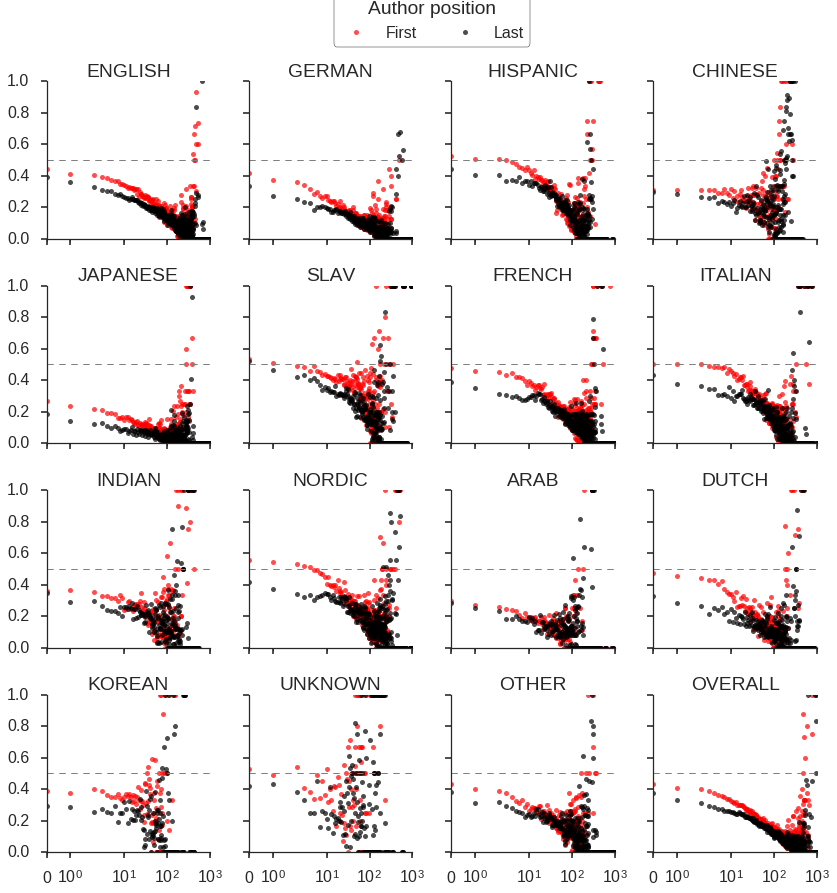

In [40]:
print """Proportion of female first and last position authorships
for each age (measured in # prior papers) grouped by various ethnicities."""

df_t, fig, ax, ethnicities = prepare_fig_age_dist(df_age_dist)
fig, ax = plot_ethnic_age_dist(df_t, fig, ax, ethnicities=ethnicities, color="r", label="First")
df_t, fig, ax, ethnicities = prepare_fig_age_dist(df_age_dist_la, fig=fig, ax=ax)
fig, ax = plot_ethnic_age_dist(df_t, fig=fig, ax=ax, color="k", label="Last")

lgd = fig.legend(*ax[0].get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0.5, 1.05),
                 ncol=2, fancybox=True, frameon=True, title="Author position")

fig.tight_layout()
plt.savefig("Eth_Age_GenderProportion.first_last.pdf", bbox_inches="tight", bbox_extra_artists=[lgd])

## Proportion of authors with first and last year of publication

In [41]:
first_last_yr_data = sqlContext.read.format("csv").options(
    header="true", delimiter="\t", inferSchema="true").load("data/AuthorityFirstLastYears.txt")

In [42]:
first_last_yr_data.dtypes

[('au_id', 'string'), ('first_year', 'int'), ('last_year', 'int')]

In [43]:
first_last_yr_data.describe().toPandas()

,summary,au_id,first_year,last_year
0,count,9300182,9300182,9300182
1,mean,None,1989.6843215541373,1994.5478053010145
2,stddev,None,16.62654287150412,15.390445124979948
3,min,10000001_1,1865,0
4,max,999999_2,9999,2099


In [44]:
CAREER_PHASE_NAMES = ["STARTED", "ENDED", "STARTED_ENDED"]

def career_filter(x, career_idx=0):
    # career_idx: 0 - first_year, 1 - last_year, 2 - both
    if career_idx > 1:
        return (
            x[0] >= 2002 and x[0] <= 2005 # first_year
            and x[1] >= 2002 and x[1] <= 2005 # last_year
               )*1
    return (x[career_idx] >= 2002 and x[career_idx] <= 2005)*1

def career_phase_count(data, first_last_yr_data, career_idx=0):
    # career_idx: 0 - first_year, 1 - last_year, 2 - both
    phase_name = CAREER_PHASE_NAMES[career_idx]
    started_dist = data.map(
        lambda x: (x[0], (x[44], x[46], x[45]))).reduceByKey(
        lambda x, y: x).map(
        lambda x: (x[1][0], tuple(x[1][1:]))).join(
        first_last_yr_data.rdd.map(
            lambda x: (x.au_id, (x.first_year, x.last_year))
        )).map(lambda x: (x[1][0], 
                          (career_filter(x[1][1], career_idx),
                           1))).reduceByKey(
        lambda x,y: (x[0] + y[0], x[1] + y[1])).collectAsMap()
    df_started_dist = pd.DataFrame([k + v for k,v in started_dist.iteritems()],
                               columns=["Ethnicity", "Gender", phase_name, "Total"])
    df_started_dist["prop"] = df_started_dist[phase_name] * 1./ df_started_dist["Total"]
    return df_started_dist

def career_phase_prop_gender(df, ethnicities=tuple(TOP_15_ETHNICITIES), career_idx=0):
    # career_idx: 0 - first_year, 1 - last_year, 2 - both
    phase_name = CAREER_PHASE_NAMES[career_idx]
    df = df.copy()
    if ethnicities is not None:
        df["Ethnicity"] = df["Ethnicity"].astype(
            "category", categories=ethnicities + ("OVERALL",), ordered=False).fillna("OTHER")
    else:
        df["Ethnicity"] = df["Ethnicity"].astype(
            "category", categories=tuple(df["Ethnicity"].unique()) + ("OVERALL",), ordered=False)
    df_t = df.pivot_table(index="Ethnicity", columns="Gender", values="prop", aggfunc=np.mean)
    if ethnicities is not None:
        df_tt = df[df["Ethnicity"] == "OTHER"].groupby("Gender")[[phase_name, "Total"]].sum()
        df_tt["prop"] = df_tt[phase_name] / df_tt["Total"]
        df_t.ix["OTHER", :] = df_tt["prop"].values
    df_tt = df.groupby("Gender")[[phase_name, "Total"]].sum()
    df_tt["prop"] = df_tt[phase_name] / df_tt["Total"]
    df_t = df_t.sort_values("F", ascending=False)
    df_t.ix["OVERALL", :] = df_tt["prop"].values
    return df_t


def merge_career_phase_tables(df_datas, ethnicities=tuple(TOP_15_ETHNICITIES), keys=tuple(CAREER_PHASE_NAMES)):
    df_t = pd.concat([career_phase_prop_gender(df_t, ethnicities=ethnicities, career_idx=i)
                  for i, df_t in enumerate(df_datas)], keys=CAREER_PHASE_NAMES, axis=1)
    if ethnicities is None:
        ethnicities = sorted([k for k in df_t.index.values if k != "OVERALL"])
    ethnicities = tuple(ethnicities) + ("OVERALL", )
    df_t = df_t.reindex(ethnicities)
    return df_t
    

### First authors

In [45]:
data = sc.textFile("out/Training_2002_2005.first_author.txt").map(lambda x: x.split("\t"))

In [46]:
df_started_dist_fa = [career_phase_count(data, first_last_yr_data, career_idx=i) for i in range(3)]

In [47]:
df_t = merge_career_phase_tables(df_started_dist_fa, ethnicities=None)
df_t

STARTED                         ENDED                      \
Gender             -         F         M         -         F         M   
AFRICAN     0.406899  0.350551  0.276119  0.320984  0.229339  0.146314   
ARAB        0.462948  0.428540  0.328173  0.330358  0.221751  0.152049   
BALTIC      0.384615  0.524590  0.354949  0.576923  0.204007  0.138225   
CARIBBEAN   0.575000  0.488372  0.105882  0.325000  0.139535  0.047059   
CHINESE     0.451784  0.433794  0.409970  0.149165  0.161048  0.136304   
DUTCH       0.411259  0.334189  0.207691  0.303866  0.158546  0.097724   
ENGLISH     0.440519  0.330977  0.229236  0.367204  0.205599  0.139129   
FRENCH      0.440292  0.305936  0.211263  0.386954  0.160312  0.097796   
GERMAN      0.507419  0.331186  0.188417  0.503710  0.194006  0.104527   
GREEK       0.447022  0.308634  0.228949  0.398299  0.139008  0.080000   
HISPANIC    0.564591  0.345872  0.261000  0.486026  0.174190  0.119175   
HUNGARIAN   0.449057  0.280117  0.148604  0.456604  0.151593  0.080274   
INDIAN      0.418362  0.411874  0.351339  0.239237  0.190346  0.132830   
INDONESIAN  0.502646  0.481481  0.376471  0.412698  0.345679  0.341176   
ISRAELI     0.320222  0.251292  0.163019  0.191962  0.138403  0.076724   
ITALIAN     0.455601  0.192534  0.117513  0.461971  0.099474  0.060366   
JAPANESE    0.253478  0.317626  0.197053  0.187246  0.230825  0.138414   
KOREAN      0.414960  0.382732  0.351932  0.155584  0.130477  0.095623   
MONGOLIAN   0.750000       NaN  0.000000  0.100000       NaN  0.000000   
NORDIC      0.428933  0.318068  0.211344  0.359607  0.185559  0.113747   
POLYNESIAN  0.500000       NaN  0.000000  1.000000       NaN  0.000000   
ROMANIAN    0.547771  0.461234  0.333799  0.503185  0.189873  0.113827   
SLAV        0.358018  0.293684  0.221019  0.357252  0.161360  0.099562   
THAI        0.409665  0.415205  0.359660  0.237175  0.235867  0.176185   
TOOSHORT    0.000000       NaN       NaN  0.000000       NaN       NaN   
TURKISH     0.342012  0.345998  0.246155  0.170121  0.116895  0.067656   
UNKNOWN     0.554572  0.415126  0.279898  0.405605  0.244538  0.167303   
VIETNAMESE  0.461390  0.372093  0.414861  0.210425  0.220930  0.238390   
OVERALL     0.429623  0.325666  0.229358  0.235676  0.179654  0.118554   

           STARTED_ENDED                      
Gender                 -         F         M  
AFRICAN         0.188119  0.131543  0.065129  
ARAB            0.220552  0.124498  0.077280  
BALTIC          0.307692  0.156648  0.076792  
CARIBBEAN       0.275000  0.093023  0.011765  
CHINESE         0.088185  0.089734  0.076036  
DUTCH           0.178386  0.062310  0.035663  
ENGLISH         0.244536  0.109424  0.064002  
FRENCH          0.246305  0.073705  0.040442  
GERMAN          0.339677  0.095929  0.041797  
GREEK           0.267595  0.073689  0.036732  
HISPANIC        0.338798  0.094419  0.061009  
HUNGARIAN       0.290566  0.061516  0.022659  
INDIAN          0.150713  0.105977  0.069774  
INDONESIAN      0.253968  0.209877  0.152941  
ISRAELI         0.121419  0.068534  0.030125  
ITALIAN         0.295616  0.041210  0.022401  
JAPANESE        0.091362  0.103040  0.050706  
KOREAN          0.100641  0.078286  0.051941  
MONGOLIAN       0.100000       NaN  0.000000  
NORDIC          0.231719  0.080342  0.043905  
POLYNESIAN      0.500000       NaN  0.000000  
ROMANIAN        0.343949  0.109968  0.063547  
SLAV            0.199579  0.077456  0.041038  
THAI            0.156877  0.137427  0.111786  
TOOSHORT        0.000000       NaN       NaN  
TURKISH         0.111476  0.063323  0.032678  
UNKNOWN         0.299410  0.147899  0.071883  
VIETNAMESE      0.142857  0.127907  0.160991  
OVERALL         0.147532  0.090686  0.052466

In [48]:
df_t = merge_career_phase_tables(df_started_dist_fa, ethnicities=tuple(TOP_15_ETHNICITIES))
df_t

STARTED                         ENDED                      \
Gender           -         F         M         -         F         M   
ENGLISH   0.440519  0.330977  0.229236  0.367204  0.205599  0.139129   
GERMAN    0.507419  0.331186  0.188417  0.503710  0.194006  0.104527   
HISPANIC  0.564591  0.345872  0.261000  0.486026  0.174190  0.119175   
CHINESE   0.451784  0.433794  0.409970  0.149165  0.161048  0.136304   
JAPANESE  0.253478  0.317626  0.197053  0.187246  0.230825  0.138414   
SLAV      0.358018  0.293684  0.221019  0.357252  0.161360  0.099562   
FRENCH    0.440292  0.305936  0.211263  0.386954  0.160312  0.097796   
ITALIAN   0.455601  0.192534  0.117513  0.461971  0.099474  0.060366   
INDIAN    0.418362  0.411874  0.351339  0.239237  0.190346  0.132830   
NORDIC    0.428933  0.318068  0.211344  0.359607  0.185559  0.113747   
ARAB      0.462948  0.428540  0.328173  0.330358  0.221751  0.152049   
DUTCH     0.411259  0.334189  0.207691  0.303866  0.158546  0.097724   
KOREAN    0.414960  0.382732  0.351932  0.155584  0.130477  0.095623   
UNKNOWN   0.554572  0.415126  0.279898  0.405605  0.244538  0.167303   
OTHER     0.387861  0.323317  0.222271  0.252094  0.147095  0.084523   
OVERALL   0.429623  0.325666  0.229358  0.235676  0.179654  0.118554   

         STARTED_ENDED                      
Gender               -         F         M  
ENGLISH       0.244536  0.109424  0.064002  
GERMAN        0.339677  0.095929  0.041797  
HISPANIC      0.338798  0.094419  0.061009  
CHINESE       0.088185  0.089734  0.076036  
JAPANESE      0.091362  0.103040  0.050706  
SLAV          0.199579  0.077456  0.041038  
FRENCH        0.246305  0.073705  0.040442  
ITALIAN       0.295616  0.041210  0.022401  
INDIAN        0.150713  0.105977  0.069774  
NORDIC        0.231719  0.080342  0.043905  
ARAB          0.220552  0.124498  0.077280  
DUTCH         0.178386  0.062310  0.035663  
KOREAN        0.100641  0.078286  0.051941  
UNKNOWN       0.299410  0.147899  0.071883  
OTHER         0.161020  0.077966  0.037752  
OVERALL       0.147532  0.090686  0.052466

## Last author

In [49]:
data = sc.textFile("out/Training_2002_2005.last_author.txt").map(lambda x: x.split("\t"))

In [50]:
df_started_dist = [career_phase_count(data, first_last_yr_data, career_idx=i) for i in range(3)]

In [51]:
df_t = merge_career_phase_tables(df_started_dist, ethnicities=None)
df_t

STARTED                         ENDED                      \
Gender             -         F         M         -         F         M   
AFRICAN     0.331269  0.219024  0.147183  0.366357  0.205257  0.149463   
ARAB        0.385370  0.318868  0.178163  0.372037  0.245047  0.137535   
BALTIC      0.459459  0.516432  0.227459  0.594595  0.276995  0.149590   
CARIBBEAN   0.354167  0.555556  0.000000  0.479167  0.111111  0.047619   
CHINESE     0.236413  0.226767  0.176232  0.119355  0.125704  0.080906   
DUTCH       0.160777  0.093262  0.031384  0.222362  0.096172  0.044072   
ENGLISH     0.331759  0.173572  0.071962  0.384187  0.168253  0.087140   
FRENCH      0.254961  0.090430  0.039748  0.344262  0.096285  0.056216   
GERMAN      0.379824  0.130800  0.043871  0.480706  0.130888  0.058750   
GREEK       0.360531  0.163061  0.072466  0.412713  0.118189  0.065780   
HISPANIC    0.438962  0.158664  0.084647  0.527744  0.131097  0.082086   
HUNGARIAN   0.475000  0.110959  0.040026  0.580000  0.123973  0.058814   
INDIAN      0.208556  0.207006  0.125455  0.206103  0.148945  0.084187   
INDONESIAN  0.208333  0.611111  0.258065  0.308333  0.388889  0.322581   
ISRAELI     0.177904  0.084371  0.035215  0.211898  0.092757  0.048795   
ITALIAN     0.379437  0.110048  0.043099  0.495308  0.093746  0.054997   
JAPANESE    0.091563  0.154895  0.049677  0.137557  0.162743  0.077369   
KOREAN      0.169795  0.192150  0.144976  0.101716  0.093213  0.061810   
MONGOLIAN   0.500000       NaN       NaN  0.333333       NaN       NaN   
NORDIC      0.263401  0.088265  0.038703  0.330505  0.097868  0.055664   
POLYNESIAN  1.000000       NaN       NaN  1.000000       NaN       NaN   
ROMANIAN    0.585859  0.257069  0.143654  0.595960  0.182519  0.114365   
SLAV        0.338595  0.194408  0.086144  0.434683  0.178835  0.085379   
THAI        0.274658  0.341584  0.149733  0.224634  0.326733  0.151515   
TOOSHORT    0.000000       NaN       NaN  0.142857       NaN       NaN   
TURKISH     0.262473  0.274447  0.170500  0.229565  0.145181  0.100790   
UNKNOWN     0.363257  0.196927  0.100505  0.461378  0.185754  0.121280   
VIETNAMESE  0.395973  0.468750  0.253731  0.315436  0.218750  0.298507   
OVERALL     0.249465  0.157878  0.067784  0.230386  0.142587  0.075240   

           STARTED_ENDED                      
Gender                 -         F         M  
AFRICAN         0.228070  0.116395  0.070661  
ARAB            0.272963  0.160142  0.074649  
BALTIC          0.324324  0.220657  0.071721  
CARIBBEAN       0.291667  0.055556  0.000000  
CHINESE         0.074352  0.073046  0.046486  
DUTCH           0.128975  0.043645  0.013649  
ENGLISH         0.265246  0.093204  0.035793  
FRENCH          0.196074  0.039694  0.015867  
GERMAN          0.317898  0.062649  0.017244  
GREEK           0.268501  0.068910  0.023515  
HISPANIC        0.350582  0.073420  0.036905  
HUNGARIAN       0.375000  0.056849  0.015684  
INDIAN          0.118025  0.086333  0.037967  
INDONESIAN      0.141667  0.333333  0.129032  
ISRAELI         0.137110  0.041423  0.014168  
ITALIAN         0.314157  0.043393  0.016214  
JAPANESE        0.061554  0.076139  0.020700  
KOREAN          0.061699  0.064186  0.031795  
MONGOLIAN       0.333333       NaN       NaN  
NORDIC          0.220208  0.042771  0.016902  
POLYNESIAN      1.000000       NaN       NaN  
ROMANIAN        0.424242  0.102828  0.069735  
SLAV            0.246397  0.093655  0.032647  
THAI            0.146767  0.200495  0.069519  
TOOSHORT        0.000000       NaN       NaN  
TURKISH         0.142781  0.084704  0.045403  
UNKNOWN         0.294363  0.115922  0.052779  
VIETNAMESE      0.214765  0.218750  0.194030  
OVERALL         0.145359  0.075867  0.028482

In [52]:
df_t = merge_career_phase_tables(df_started_dist, ethnicities=tuple(TOP_15_ETHNICITIES))
df_t

STARTED                         ENDED                      \
Gender           -         F         M         -         F         M   
ENGLISH   0.331759  0.173572  0.071962  0.384187  0.168253  0.087140   
GERMAN    0.379824  0.130800  0.043871  0.480706  0.130888  0.058750   
HISPANIC  0.438962  0.158664  0.084647  0.527744  0.131097  0.082086   
CHINESE   0.236413  0.226767  0.176232  0.119355  0.125704  0.080906   
JAPANESE  0.091563  0.154895  0.049677  0.137557  0.162743  0.077369   
SLAV      0.338595  0.194408  0.086144  0.434683  0.178835  0.085379   
FRENCH    0.254961  0.090430  0.039748  0.344262  0.096285  0.056216   
ITALIAN   0.379437  0.110048  0.043099  0.495308  0.093746  0.054997   
INDIAN    0.208556  0.207006  0.125455  0.206103  0.148945  0.084187   
NORDIC    0.263401  0.088265  0.038703  0.330505  0.097868  0.055664   
ARAB      0.385370  0.318868  0.178163  0.372037  0.245047  0.137535   
DUTCH     0.160777  0.093262  0.031384  0.222362  0.096172  0.044072   
KOREAN    0.169795  0.192150  0.144976  0.101716  0.093213  0.061810   
UNKNOWN   0.363257  0.196927  0.100505  0.461378  0.185754  0.121280   
OTHER     0.281319  0.195343  0.093688  0.280081  0.136455  0.077179   
OVERALL   0.249465  0.157878  0.067784  0.230386  0.142587  0.075240   

         STARTED_ENDED                      
Gender               -         F         M  
ENGLISH       0.265246  0.093204  0.035793  
GERMAN        0.317898  0.062649  0.017244  
HISPANIC      0.350582  0.073420  0.036905  
CHINESE       0.074352  0.073046  0.046486  
JAPANESE      0.061554  0.076139  0.020700  
SLAV          0.246397  0.093655  0.032647  
FRENCH        0.196074  0.039694  0.015867  
ITALIAN       0.314157  0.043393  0.016214  
INDIAN        0.118025  0.086333  0.037967  
NORDIC        0.220208  0.042771  0.016902  
ARAB          0.272963  0.160142  0.074649  
DUTCH         0.128975  0.043645  0.013649  
KOREAN        0.061699  0.064186  0.031795  
UNKNOWN       0.294363  0.115922  0.052779  
OTHER         0.177792  0.076010  0.030447  
OVERALL       0.145359  0.075867  0.028482